In [16]:
import torch
import torchvision
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [18]:
device = torch.device("cuda")

In [20]:
from constant import CONFIG

CONFIG

SAMConfig(sam2_checkpoint='../sam2/checkpoints/sam2.1_hiera_large.pt', model_cfg='../sam2/configs/sam2.1/sam2.1_hiera_l.yaml')

In [21]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = CONFIG.sam2_checkpoint
model_cfg = CONFIG.model_cfg

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [22]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

Frames extracted and saved to temp\test


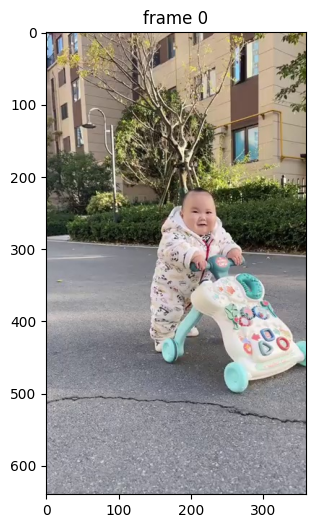

In [35]:
import re


# Path to the frames directory
video_dir = r"temp\test"

# List all image files (frames)
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
]

# Sort by extracting the numeric part of the filename (e.g., 'frame_0000' -> 0000)
frame_names.sort(key=lambda p: int(re.search(r'\d+', os.path.splitext(p)[0]).group()))

# Display the first frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
plt.show()